## Multinomial Naive Bayes Modeling and Metrics With TF-IDF Vectorier
---

## Contents
---
- [Library and Data Imports](#Library-and-Data-Imports)
- [Train Test Split and Base Model](#Train-Test-Split-and-Base-Model)
- [Multinomial Naive Bayes with CountVectorizer](#Multinomial-Naive-Bayes-with-CountVectorizer)
- [Predictions and Interpretation](#Predictions-and-Interpretation)|
- [Confusion Matrix Interpretation](#Confusion-Matrix-Interpretation)

## Library and Data Imports
___

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,accuracy_score,
    roc_auc_score, recall_score,
    precision_score, f1_score, classification_report, RocCurveDisplay)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from matplotlib.ticker import FuncFormatter

**Read in text_processed_corpus.csv**

In [2]:
text_processed_corpus = pd.read_csv('../data/text_processed_corpus.csv')

## Train Test Split and Base Model
___

In [3]:
#Train Test Split
X = text_processed_corpus['processed_text']
y = text_processed_corpus['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    stratify = y,
                                                    random_state = 24)
                                                    
    

**What is the base model?**
* There is a **56%** chance of correctly predicting a post belongs in the fountainpens reddit.

In [4]:
y.value_counts(normalize = True) * 100

subreddit
1    55.615165
0    44.384835
Name: proportion, dtype: float64

In [5]:
#Ensuring that stratify is maintaining the slight skew between the two subreddit
y_train.value_counts(normalize = True), y_test.value_counts(normalize = True)

(subreddit
 1    0.556032
 0    0.443968
 Name: proportion, dtype: float64,
 subreddit
 1    0.556509
 0    0.443491
 Name: proportion, dtype: float64)

In [6]:
# Summon the vectorizers and estimators
cvec = CountVectorizer()
logreg = LogisticRegression()

## Multinomial Naive Bayes with CountVectorizer
___
In my initial attempt at this project, I used the Bernoulli Naive Bayes model, which tracks whether words are present or not. Although it performed well, the main feedback I received was to try the Multinomial Naive Bayes model instead. This notebook will focus on building and evaluating the performance of the Multinomial Naive Bayes model.

In [7]:
# Build a pipeline
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mb', MultinomialNB())
])

In [8]:
# Checking an initial score without actually fitting anything.
cross_val_score(pipe, X_train, y_train, cv=3).mean()

0.8741058655221745

A variety of wide ranges were set for each parameter.  Several interations were run until each parameter range was narrowed down to the best ones.

Each range would start with 3 or 4 variables and be adjusted depending if values preferred higher or lower variables.

In [9]:
# Create parameters for a gridsearch over to see what performs best
# I did not include a stop_words parameter becuse this was already done with SpaCy
pipe_params = {
    'mb__alpha':[0.95],
    'cvec__max_features': [2000],
    'cvec__min_df': [3],
    'cvec__max_df': [0.7],
    'cvec__ngram_range': [(1,3)]
}

In [10]:
#GridSearch set-up
gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = 5)

In [11]:
#GridSearch the training data.

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.7], 'cvec__max_features': [2000],
                         'cvec__min_df': [3], 'cvec__ngram_range': [(1, 3)],
                         'mb__alpha': [0.95]})

In [12]:
#What was the best score?
print(f'The best accuracy score in all models tested in grid search is {round(gs.best_score_,2) * 100}%')

The best accuracy score in all models tested in grid search is 87.0%


In [13]:
# Breakdown of the parameters chosen to make the best model.
gs.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 2000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 3),
 'mb__alpha': 0.95}

## Predictions and Interpretation
___

Results - Model resulted in ~91% for both the training and testing accuracy score which is the best of any attempted model.  The prediction accurary is 91%

#### Predictions

In [14]:
#Training set results
print(f'Training accuracy score is at {round(gs.score(X_train, y_train)* 100,2)}%')

Training accuracy score is at 90.56%


In [15]:
# Testing set results - Null model is at 56%
print(f'Testing accuracy score is at {round(gs.score(X_test, y_test)* 100,2)}%')

Testing accuracy score is at 90.84%


In [16]:
# The next two slides show how the model predicts (fountainpens = 1 and pens = 0) and the probability for each row value.
# First 20 samples are shown.
pred = gs.predict(X_test)
pred[:20]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
      dtype=int64)

In [17]:
gs.predict_proba(X_test)[:20]

array([[4.35621209e-01, 5.64378791e-01],
       [2.74228770e-05, 9.99972577e-01],
       [9.01120522e-04, 9.99098879e-01],
       [4.82284210e-04, 9.99517716e-01],
       [9.88730653e-01, 1.12693467e-02],
       [1.09318310e-02, 9.89068169e-01],
       [2.90899539e-01, 7.09100461e-01],
       [5.11318533e-02, 9.48868147e-01],
       [4.56932183e-02, 9.54306782e-01],
       [1.09895673e-04, 9.99890104e-01],
       [1.22206370e-28, 1.00000000e+00],
       [5.87152048e-06, 9.99994128e-01],
       [1.44347143e-08, 9.99999986e-01],
       [3.88081217e-01, 6.11918783e-01],
       [5.55468845e-12, 1.00000000e+00],
       [9.89025297e-01, 1.09747029e-02],
       [1.72469886e-05, 9.99982753e-01],
       [6.65955927e-08, 9.99999933e-01],
       [1.82103491e-01, 8.17896509e-01],
       [1.45898273e-03, 9.98541017e-01]])

In [18]:
# Accuracy Score - What precentage of total predictions were correct?
print(f'This model has an accuracy score of {round(metrics.accuracy_score(y_test, pred) * 100,2)}%')

This model has an accuracy score of 90.84%


## Confusion Matrix Interpretation
___
In this scenerio, I would ideally prefer to never incorrectly classify a pen subreddit post as a fountainpens post.  Pens are a more general topic and talking about fountain pens would be acceptable.  It's safe to assume people browsing the fountainpens subreddit are only interested in fountain pens.<br><br>
Essentially I want to mimimize false positives.  **The specificity score is ~88%**.  This model is more accurate, but doesn't do as well with specificity as Bernoulli Naive Bayes.

In [19]:
#Create a confusion matrix array
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

print(tn, fp, fn, tp)

273 37 27 362


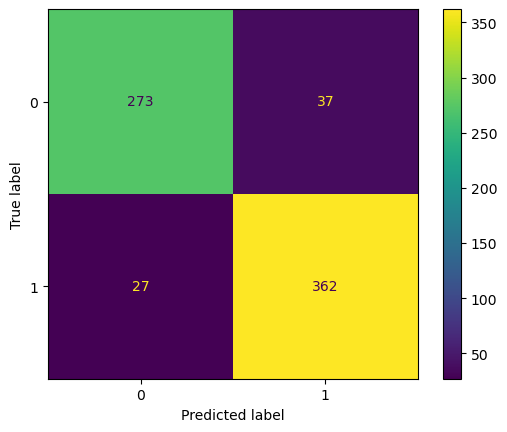

In [20]:
#Create a confusion matrix
#Create a confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred),
                             display_labels=gs.classes_)

disp.plot()
plt.savefig('../plot_images/multinomial_nb_cvec_confusion_matrix.png', dpi = 192);

In [21]:
# How sensitive is this model? ~93%
metrics.recall_score(y_test, pred)

0.9305912596401028

In [22]:
# What is the specificity of the model?  - I care about this metric more.  Score is ~88%
tn / (tn + fp)

0.8806451612903226

In [23]:
# Recall is the same as sensitivity ~93%
metrics.recall_score(y_test, pred)

0.9305912596401028

In [24]:
# Precision score.  How many were correctly predicted to go in the fountainpens reddit?
metrics.precision_score(y_test, pred)

0.9072681704260651

<Figure size 2000x800 with 0 Axes>

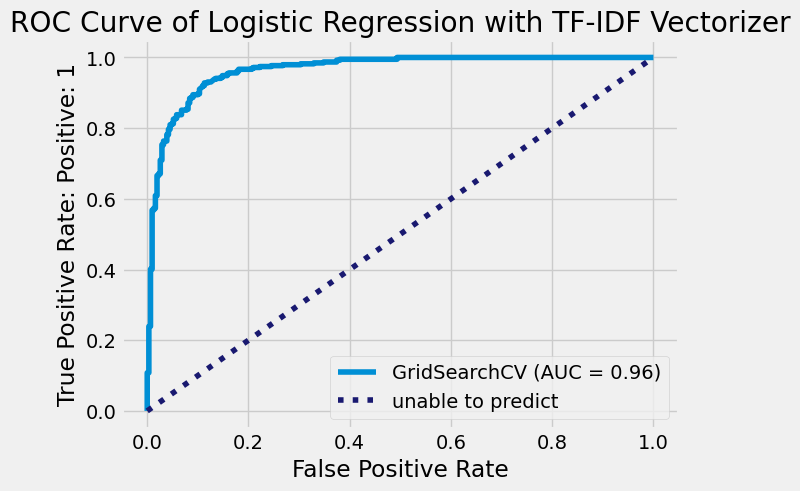

In [25]:
plt.figure(figsize = (20,8))
plt.style.use("fivethirtyeight")
plt.tight_layout()

RocCurveDisplay.from_estimator(gs, X_test, y_test)

# The 50/50 line
plt.plot([0,1], [0,1],
         label = 'unable to predict',
         linestyle = 'dotted',
         color = 'midnightblue');

# Legend
plt.legend()
plt.title('ROC Curve of Logistic Regression with TF-IDF Vectorizer')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate: Positive: 1');

In [26]:
#F1 Score - Unsure if this is meaningful because the classes weren't very unbalanced.
f1_score(y_test, pred)

0.9187817258883249

Predicted probability chart to compare against Bernoulli Naive Bayes model.  This model

In [27]:
pred_df = pd.DataFrame(
    gs.predict_proba(X_test),
    columns=['pens', 'fountainpens'])

pred_df['true_values'] = y_test.values

pred_df.head()

,pens,fountainpens,true_values
0,0.435621,0.564379,1
1,0.000027,0.999973,1
2,0.000901,0.999099,1
3,0.000482,0.999518,1
4,0.988731,0.011269,0


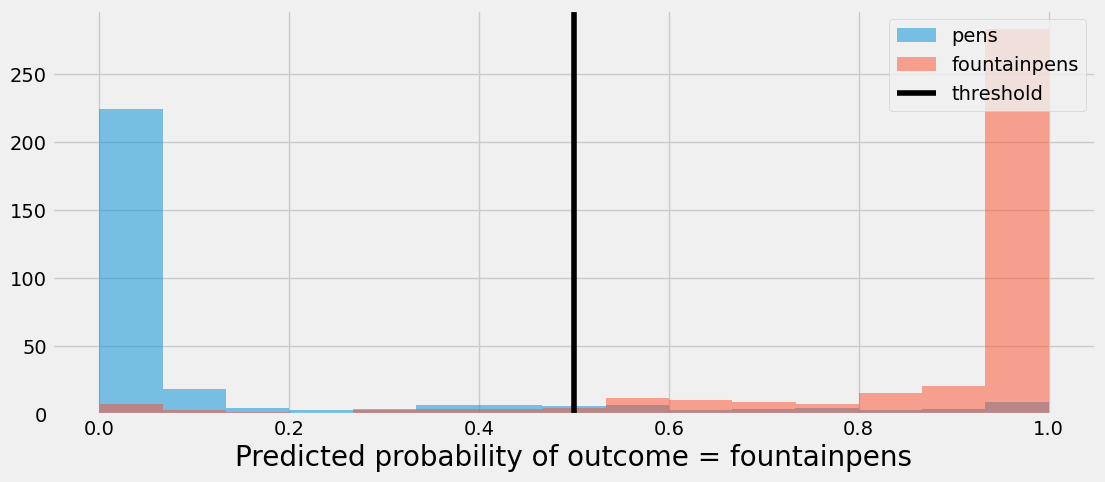

In [28]:
plt.figure(figsize=(12,5))
plt.tight_layout()

alive_subset = pred_df[pred_df['true_values'] == 0]
plt.hist(alive_subset['fountainpens'], label='pens', bins=15, alpha=.5)

dead_subset = pred_df[pred_df['true_values'] == 1]
plt.hist(dead_subset['fountainpens'], label='fountainpens', bins=15, alpha=.5)

plt.axvline(.5, color='black', linestyle='-', label='threshold')
plt.xlabel('Predicted probability of outcome = fountainpens', size = 20)

plt.legend();